# Tutorial 5: Uncovering Latent Dimensionality

This tutorial covers one of the interesting applications of mutual information: discovering the **latent dimensionality** of a system. This technique allows us to ask not just *how much* information is shared, but *how complex* that shared information is.

We will explore two related but distinct scientific questions:

1.  **Shared Dimensionality:** What is the dimensionality of the information shared *between* two variables, X and Y?
2.  **Internal Dimensionality:** What is the intrinsic complexity of a *single*, high-dimensional neural population?

We will see how `NeuralMI` can answer both questions and learn why the choice of MI estimator (`InfoNCE` vs. `SMILE`) and model type (`variational`) is critical for getting the right answer.

In [1]:
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set_context("talk")

## 1. Shared Dimensionality between X and Y

Let's start with a common question: if X and Y are related, what is the dimensionality of their shared relationship? We can investigate this by performing a simple sweep over the `embedding_dim` of a `SeparableCritic`.

The `embedding_dim` acts as an **information bottleneck**. We expect the measured MI to rise as this bottleneck widens and then **plateau** once it's large enough to capture the full shared signal. The location of this plateau is our estimate of the shared dimensionality.

For this task, the default **InfoNCE** estimator is often an excellent choice due to its stability and low variance.

In [2]:
# --- Generate Data ---
# We'll create 100D X and Y variables that non-linearly share a 7D latent signal.
true_latent_dim = 7
x_raw, y_raw = nmi.datasets.generate_nonlinear_from_latent(
    n_samples=5000, 
    latent_dim=true_latent_dim,
    observed_dim=100,
    mi=3.0 # The MI between the latent variables
)
x_raw_transposed = x_raw.T.detach()
y_raw_transposed = y_raw.T.detach()

In [3]:
# Base parameters for the trainer
base_params = {
    'n_epochs': 50, 'learning_rate': 1e-3, 'batch_size': 256,
    'patience': 10, 'hidden_dim': 128, 'n_layers': 3
}

# We sweep over the embedding_dim using a standard 'sweep' mode
sweep_grid = {
    'embedding_dim': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20],
    'run_id': range(3) # Average for stability
}

shared_dim_results = nmi.run(
    x_data=x_raw_transposed,
    y_data=y_raw_transposed,
    mode='sweep', # Note: we use 'sweep', not 'dimensionality' for this question
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    split_mode='random',
    base_params=base_params,
    sweep_grid=sweep_grid,
    n_workers=4,
    random_seed=42
)

2025-10-20 00:06:19 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-20 00:06:19 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/39 [00:00<?, ?task/s]

2025-10-20 00:07:03 - neural_mi - INFO - Parameter sweep finished.


The resulting curve clearly rises and then begins to saturate right around the true latent dimension of 7 (and also gets the right MI value). Usually the saturation happens 1 dimension after the correct one, this *extra* dimension allows for some wiggle room to capturea all the information. This is a beuatiful way of finding the shared dimensionality.

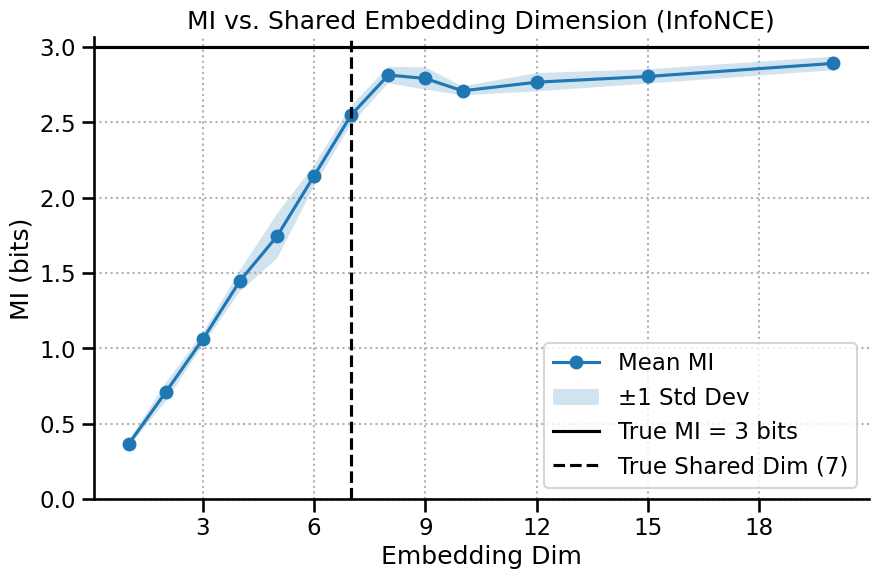

In [4]:
ax = shared_dim_results.plot(show=False)
ax.axhline(y=3.0, color='black', linestyle='-', label=f'True MI = 3 bits')
ax.axvline(x=true_latent_dim, color='black', linestyle='--', label=f'True Shared Dim ({true_latent_dim})')
ax.set_title('MI vs. Shared Embedding Dimension (InfoNCE)')
ax.legend()
ax.set_ylim(bottom=0)
plt.show()

## 2. Internal Dimensionality of a Single Population

Now for a more advanced question: what is the internal complexity of a *single* variable `X`? For this, we use `mode='dimensionality'`. This mode automatically splits the channels of `X` into two random halves (`X_A` and `X_B`) and measures the "Internal Information" `I(X_A; X_B)`.

As we've discussed, this is a special, high-information scenario. It's the perfect place to compare our different estimators.

### 2.1 Analysis with InfoNCE vs. SMILE

Let's run the analysis twice: once with the default `InfoNCE` estimator, and once with the less-biased `SMILE` estimator.

In [5]:
sweep_grid_dim = {
    'embedding_dim': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20],
}

print("--- Running with InfoNCE ---")
dim_results_infonce = nmi.run(
    x_data=x_raw_transposed,
    mode='dimensionality',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    base_params=base_params,
    sweep_grid=sweep_grid_dim,
    split_mode='random',
    estimator='infonce', # Default, but explicit here for clarity
    n_splits=3, # Average over 3 random splits for stability, Note that for accurate results, we probably need more splits
    n_workers=4,
    random_seed=42
)

print("\n--- Running with SMILE ---")
dim_results_smile = nmi.run(
    x_data=x_raw_transposed,
    mode='dimensionality',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    base_params=base_params,
    sweep_grid=sweep_grid_dim,
    split_mode='random',
    estimator='smile',
    estimator_params={'clip': 1.0},
    n_splits=3, # Average over 3 random splits for stability, Note that for accurate results, we probably need more splits
    n_workers=4,
    random_seed=42
)

--- Running with InfoNCE ---
2025-10-20 00:07:03 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-20 00:07:03 - neural_mi - WARNING - Using 'infonce' estimator for dimensionality analysis. For this specific mode, consider using the 'smile' estimator, as its lower bias may reveal the saturation point more clearly.
2025-10-20 00:07:03 - neural_mi - INFO - --- Running Split 1/3 ---
2025-10-20 00:07:03 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-10-20 00:07:27 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:07:27 - neural_mi - INFO - --- Running Split 2/3 ---
2025-10-20 00:07:27 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

Run 616ab454-97af-4d32-a15c-d5e70aee9f38_c12 | MI: 8.945:  94%|█████████▍| 47/50 [00:07<00:00,  5.92it/s] 

2025-10-20 00:07:54 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:07:54 - neural_mi - INFO - --- Running Split 3/3 ---
2025-10-20 00:07:54 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

2025-10-20 00:08:17 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:08:17 - neural_mi - INFO - --- Dimensionality Analysis Complete ---

--- Running with SMILE ---
2025-10-20 00:08:17 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-20 00:08:17 - neural_mi - INFO - --- Running Split 1/3 ---
2025-10-20 00:08:17 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

Run 71283516-a8a6-4bdd-ae23-f5edfe359173_c12 | MI: 10.195:  98%|█████████▊| 49/50 [00:07<00:00,  6.15it/s]

2025-10-20 00:08:42 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:08:42 - neural_mi - INFO - --- Running Split 2/3 ---
2025-10-20 00:08:42 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

Run 7bea3a4c-ceea-4ea1-926e-8c5e51484909_c12 | MI: 8.843:  66%|██████▌   | 33/50 [00:04<00:02,  6.72it/s] 

2025-10-20 00:09:04 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:09:04 - neural_mi - INFO - --- Running Split 3/3 ---
2025-10-20 00:09:04 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

Run bdc9fb08-ebd8-4908-809b-2147180613f7_c11 | MI: 10.074:  82%|████████▏ | 41/50 [00:06<00:01,  6.37it/s]

2025-10-20 00:09:27 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:09:27 - neural_mi - INFO - --- Dimensionality Analysis Complete ---


### 2.2 An Even Better Estimator? The Variational Approach

We've seen that SMILE is better than InfoNCE for this task because it's less biased. Can we do even better? For very complex, high-dimensional data, a standard model might struggle to create a good representation. 

A **variational** model (like `VarMLP`) adds a layer of sophistication: instead of learning a single embedding vector for each data point, it learns a *distribution* (a mean and a variance) over the embedding space. This acts as a form of regularization, which can help stabilize training and lead to a more robust estimate, especially in high-MI regimes.

In [6]:
print("\n--- Running with Variational SMILE ---")
dim_results_smile_var = nmi.run(
    x_data=x_raw_transposed,
    mode='dimensionality',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    base_params={**base_params, 'use_variational': True, 'beta':1/1024}, # Enable the variational model
    sweep_grid=sweep_grid_dim,
    split_mode='random',
    estimator='smile', 
    estimator_params={'clip': 1},
    n_splits=3,
    n_workers=4,
    random_seed=42
)


--- Running with Variational SMILE ---
2025-10-20 00:09:27 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-20 00:09:27 - neural_mi - INFO - --- Running Split 1/3 ---
2025-10-20 00:09:27 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

Run 97f5873b-23c7-448d-9c1b-bc34b895399e_c12 | MI: 9.543:  98%|█████████▊| 49/50 [00:07<00:00,  5.72it/s]

2025-10-20 00:09:56 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:09:56 - neural_mi - INFO - --- Running Split 2/3 ---
2025-10-20 00:09:56 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

Run 2d39a112-7381-43a5-86aa-30fe8a3e08b7_c12 | MI: 7.888:  68%|██████▊   | 34/50 [00:05<00:02,  5.89it/s]

2025-10-20 00:10:24 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:10:24 - neural_mi - INFO - --- Running Split 3/3 ---
2025-10-20 00:10:24 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/13 [00:00<?, ?task/s]

Run f0bac7f2-aa16-4dcc-b102-37571db56e6a_c12 | MI: 10.650:  98%|█████████▊| 49/50 [00:09<00:00,  5.27it/s]

2025-10-20 00:10:58 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:10:58 - neural_mi - INFO - --- Dimensionality Analysis Complete ---


## 3. Comparison and Conclusion

Let's plot all three curves on the same axes. The difference is clear. 

The **InfoNCE** curve flattens out abruptly, likely hitting slighlty around its theoretical maximum value (`log(256) ≈ 8` bits for our batch size). 

The **SMILE** curve, being less biased, continues to rise and shows a more accurate saturation point near the true latent dimension of 7, albiet it's very noisy.

The **Variational SMILE** curve follows a similar path but is much smoother and more stable, providing the most confident estimate of the saturation point. It has lower variance like InfoNCE, but reaches the correct dimensionality like SMILE.

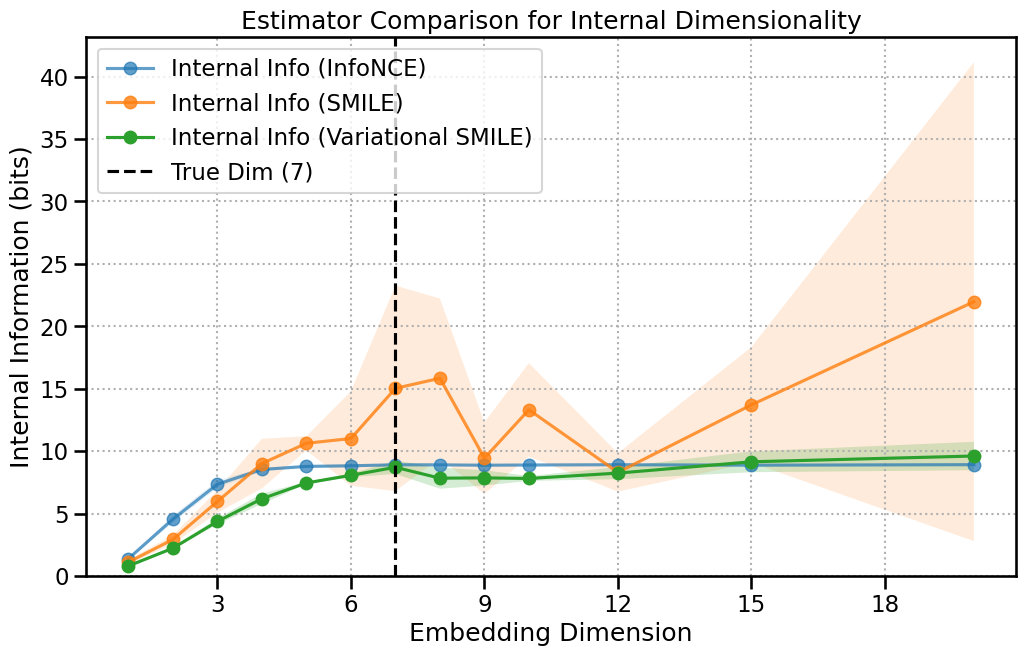

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Plot InfoNCE results
df_i = dim_results_infonce.dataframe
ax.plot(df_i['embedding_dim'], df_i['mi_mean'], 'o-', label='Internal Info (InfoNCE)', alpha=0.7)
ax.fill_between(df_i['embedding_dim'], df_i['mi_mean'] - df_i['mi_std'], df_i['mi_mean'] + df_i['mi_std'], alpha=0.1)

# Plot SMILE results
df_s = dim_results_smile.dataframe
ax.plot(df_s['embedding_dim'], df_s['mi_mean'], 'o-', label='Internal Info (SMILE)', alpha=0.8)
ax.fill_between(df_s['embedding_dim'], df_s['mi_mean'] - df_s['mi_std'], df_s['mi_mean'] + df_s['mi_std'], alpha=0.15)

# Plot Variational SMILE results
df_v = dim_results_smile_var.dataframe
ax.plot(df_v['embedding_dim'], df_v['mi_mean'], 'o-', label='Internal Info (Variational SMILE)')
ax.fill_between(df_v['embedding_dim'], df_v['mi_mean'] - df_v['mi_std'], df_v['mi_mean'] + df_v['mi_std'], alpha=0.2)

ax.axvline(x=true_latent_dim, color='black', linestyle='--', label=f'True Dim ({true_latent_dim})')
ax.set_title('Estimator Comparison for Internal Dimensionality')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Internal Information (bits)')
ax.legend()
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim(bottom=0)
plt.show()

### Final Recommendations:
- To find the dimensionality of the **shared signal between X and Y**, a standard `mode='sweep'` with the default **`InfoNCE`** estimator is a great choice.
- To find the **internal dimensionality of a single population `X`**, use `mode='dimensionality'` and start with the **`SMILE`** estimator for a less biased result.
- For particularly high-dimensional or complex data, consider using **`use_variational=True`** with SMILE to get the most stable and reliable curve.

*Note*: The variational estimators often require slightly more training to reach good estimates, thus consider increasing the number of epochs and patience when using them.